# Exploring the Effects of Transfer Learning on Bayesian Convolutional Neural Network For classifying Cataract in Ocular Disease

## Bayesian Convolutional Neural Network

### Importing Libraries 

In [84]:
import numpy as np
import pandas as pd
import os
import glob
import random
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2
from random import shuffle 
from IPython.display import SVG
import pickle
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os
import shutil
import time
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (12, 6)
import splitfolders

#### Importing and Viewing Ocular Disease Intelligent Recognition (ODIR) Dataset

In [2]:
df = pd.read_csv("archive/full_df.csv")

In [3]:
# Viewing the first 5 observations
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


### Exploratory Data Analysis 

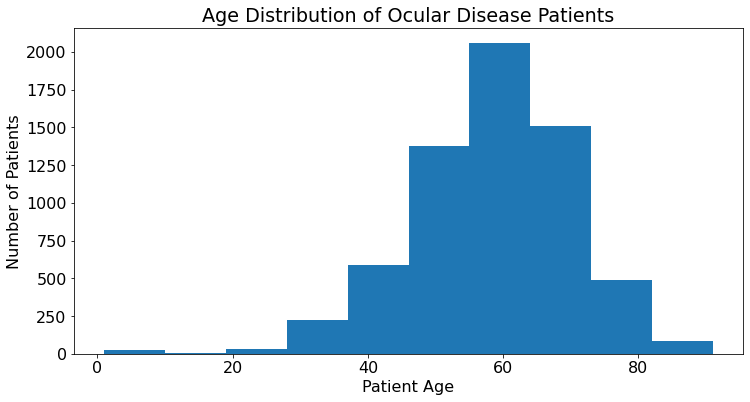

In [4]:
plt.hist(df['Patient Age']);
plt.title("Age Distribution of Ocular Disease Patients")
plt.xlabel("Patient Age")
plt.ylabel("Number of Patients")
plt.show()

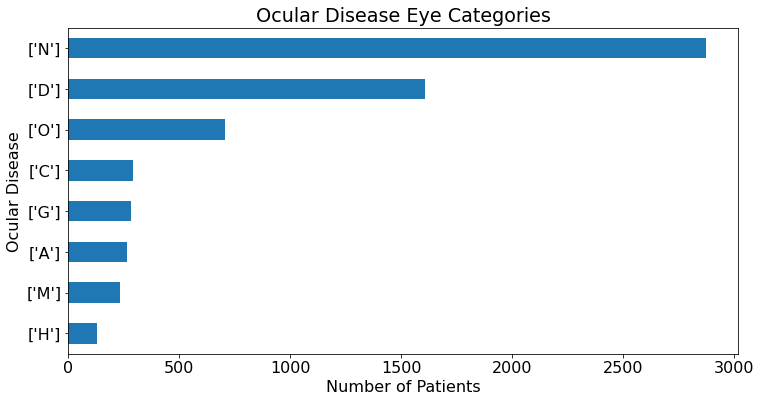

In [5]:
df['labels'].value_counts().sort_values().plot(kind = 'barh');
plt.title("Ocular Disease Eye Categories")
plt.ylabel("Ocular Disease")
plt.xlabel("Number of Patients")
plt.show()

### Extracting Cataract & Normal Class Information from the ODIR Dataset

In [6]:
# Function to check if texts have the word cataract
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [7]:
# Creating columns with cataract labels
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [8]:
# Extracting cataract image names from the left eye diagnostic
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:5]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg'], dtype=object)

In [9]:
# Extracting cataract image names from the right eye diagnostic
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:5]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg'], dtype=object)

In [10]:
# Number of images for left and right eye cataract 
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [14]:
# Creating a Dataframe of Left and Right eye Cataract Images
left_catarct_dataframe = df.loc[(df.C ==1) & (df.left_cataract == 1)]
right_cataract_dataframe = df.loc[(df.C ==1) & (df.right_cataract == 1)]
cataract_lr_df = pd.concat([left_catarct_dataframe, right_cataract_dataframe])

In [20]:
# Randomly extracting normal eye images for left and right eye diagnostic
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values

In [21]:
# Combining left and right eye image names for cataract and normal eyes
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [22]:
# Sample of Cataract Image filenames
cataract[:5]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg'], dtype=object)

In [23]:
# Sample of Normal Image filenames
normal[:5]

array(['3332_left.jpg', '4059_left.jpg', '69_left.jpg', '2415_left.jpg',
       '4176_left.jpg'], dtype=object)

In [24]:
print("Number of normal eye image names: {}".format(len(normal)))
print("Number of cataract eye image names: {}".format(len(cataract)))

Number of normal eye image names: 500
Number of cataract eye image names: 594


### Cataract Dataset Exploratory Analysis 

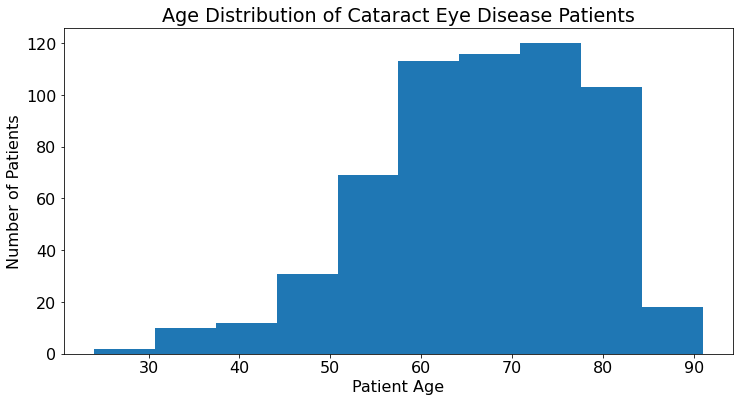

In [25]:
plt.hist(cataract_lr_df['Patient Age']);
plt.title("Age Distribution of Cataract Eye Disease Patients")
plt.xlabel("Patient Age")
plt.ylabel("Number of Patients")
plt.show()

In [27]:
# Statistical Summary of Cataract Patient Age
cataract_lr_df['Patient Age'].describe()

count    594.000000
mean      66.742424
std       11.719285
min       24.000000
25%       60.000000
50%       68.000000
75%       75.000000
max       91.000000
Name: Patient Age, dtype: float64

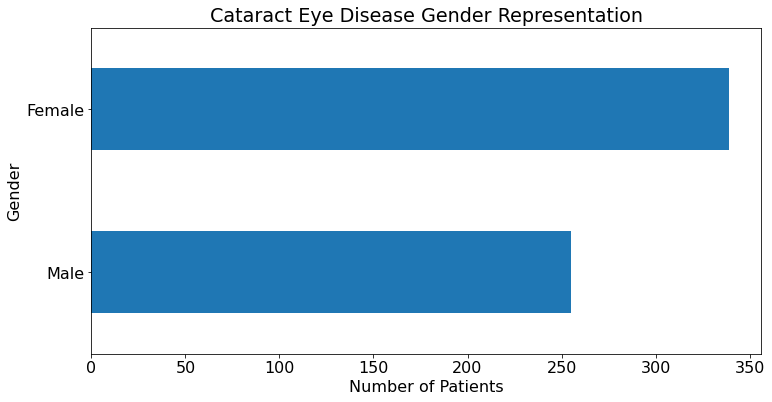

In [26]:
cataract_lr_df['Patient Sex'].value_counts().sort_values().plot(kind = 'barh');
plt.title("Cataract Eye Disease Gender Representation")
plt.ylabel("Gender")
plt.xlabel("Number of Patients")
plt.show()

### Copying Normal and Cataract Images Files to New Destination for Modelling

In [59]:
# Normal Images
source = 'archive/preprocessed_images/'
destination = 'archive/ocular_disease_data/Normal/'
  
for img in tqdm(normal):
    shutil.copyfile(source + img, destination + img)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1740.51it/s]


In [65]:
# Cataract Images
source = 'archive/preprocessed_images/'
destination = 'archive/ocular_disease_data/Cataract/'
  
for img in tqdm(cataract):
    try:
        shutil.copyfile(source + img, destination + img)
    except IOError as e:
        print(e)

 80%|██████████████████████████████████████████████████████████████▋               | 477/594 [00:00<00:00, 2236.28it/s]

[Errno 2] No such file or directory: 'archive/preprocessed_images/2102_left.jpg'
[Errno 2] No such file or directory: 'archive/preprocessed_images/2231_left.jpg'
[Errno 2] No such file or directory: 'archive/preprocessed_images/2244_left.jpg'
[Errno 2] No such file or directory: 'archive/preprocessed_images/2251_left.jpg'
[Errno 2] No such file or directory: 'archive/preprocessed_images/1456_right.jpg'


100%|██████████████████████████████████████████████████████████████████████████████| 594/594 [00:00<00:00, 2309.93it/s]

[Errno 2] No such file or directory: 'archive/preprocessed_images/2229_right.jpg'


### Creating a Train and Test Dataset

In [67]:
input_dir = os.path.join('archive/ocular_disease_data/')
output_dir = os.path.join('archive/ocular_disease_data_splitted/')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.9, .1), group_prefix=None) 

Copying files: 782 files [00:02, 322.41 files/s]


In [30]:
train_dir = os.path.join('archive/ocular_disease_data_splitted/train/')
test_dir = os.path.join('archive/ocular_disease_data_splitted/val/')

### Data Preprocessing and Transformation

In [31]:
def image_generator(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 44,
                                  class_mode = 'categorical',
                                  subset='training')
 
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 4,
                                 class_mode = 'categorical')    
    
    return train_generator, test_generator

In [32]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 702 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


## Modelling 
## Standard Convolutional Neural Network (CNN)

### CNN Model Architecture 

In [33]:
model = Sequential([
    Conv2D(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(units=2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 8)         6152      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

### Compiling CNN Model

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### CNN Model Training 

In [38]:
checkpoint_model = ModelCheckpoint("cnn_model_1.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
#earlystop_model = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)
#model_bayesian_history = model_bayesian.fit(x_train,y_train,batch_size=32,epochs=50,validation_data=(x_test,y_test),
#                                           callbacks=[checkpoint_bayesian,earlystop_bayesian])

In [40]:
start = time.time()
history = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=100,
      validation_data = test_generator,
      verbose=1,
      callbacks = [checkpoint_model])
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.6187
Epoch 1: val_accuracy improved from -inf to 0.61250, saving model to cnn_model_1.h5
10/10 [==============================] - 4s 331ms/step - loss: 0.6680 - accuracy: 0.6187 - val_loss: 0.6634 - val_accuracy: 0.6125
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.6164
Epoch 2: val_accuracy did not improve from 0.61250
10/10 [==============================] - 2s 210ms/step - loss: 0.6474 - accuracy: 0.6164 - val_loss: 0.6435 - val_accuracy: 0.6125
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6164
Epoch 3: val_accuracy did not improve from 0.61250
10/10 [==============================] - 2s 188ms/step - loss: 0.6502 - accuracy: 0.6164 - val_loss: 0.6291 - val_accuracy: 0.6125
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6164
Epoch 4: val_accuracy improved from 0.612

10/10 [==============================] - 2s 197ms/step - loss: 0.2356 - accuracy: 0.9110 - val_loss: 0.2387 - val_accuracy: 0.9375
Epoch 30/100
10/10 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9247
Epoch 30: val_accuracy did not improve from 0.93750
10/10 [==============================] - 2s 210ms/step - loss: 0.1988 - accuracy: 0.9247 - val_loss: 0.2430 - val_accuracy: 0.9250
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9155
Epoch 31: val_accuracy did not improve from 0.93750
10/10 [==============================] - 2s 192ms/step - loss: 0.2026 - accuracy: 0.9155 - val_loss: 0.2531 - val_accuracy: 0.9000
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9247
Epoch 32: val_accuracy did not improve from 0.93750
10/10 [==============================] - 2s 187ms/step - loss: 0.2022 - accuracy: 0.9247 - val_loss: 0.2531 - val_accuracy: 0.8750
Epoch 33/100
10/10 [============

Epoch 59/100
10/10 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9886
Epoch 59: val_accuracy did not improve from 0.95000
10/10 [==============================] - 3s 256ms/step - loss: 0.0444 - accuracy: 0.9886 - val_loss: 0.3294 - val_accuracy: 0.9250
Epoch 60/100
10/10 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9932
Epoch 60: val_accuracy did not improve from 0.95000
10/10 [==============================] - 3s 250ms/step - loss: 0.0300 - accuracy: 0.9932 - val_loss: 0.3597 - val_accuracy: 0.9125
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9932
Epoch 61: val_accuracy did not improve from 0.95000
10/10 [==============================] - 3s 252ms/step - loss: 0.0265 - accuracy: 0.9932 - val_loss: 0.4231 - val_accuracy: 0.9125
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9977
Epoch 62: val_accuracy did not improve from 0.95000
10/10 [========

10/10 [==============================] - 2s 199ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6489 - val_accuracy: 0.9125
Epoch 89/100
10/10 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000
Epoch 89: val_accuracy did not improve from 0.95000
10/10 [==============================] - 2s 200ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6507 - val_accuracy: 0.9125
Epoch 90/100
10/10 [==============================] - ETA: 0s - loss: 8.7676e-04 - accuracy: 1.0000
Epoch 90: val_accuracy did not improve from 0.95000
10/10 [==============================] - 2s 201ms/step - loss: 8.7676e-04 - accuracy: 1.0000 - val_loss: 0.6486 - val_accuracy: 0.9250
Epoch 91/100
10/10 [==============================] - ETA: 0s - loss: 8.9017e-04 - accuracy: 1.0000
Epoch 91: val_accuracy did not improve from 0.95000
10/10 [==============================] - 2s 201ms/step - loss: 8.9017e-04 - accuracy: 1.0000 - val_loss: 0.6813 - val_accuracy: 0.9250
Epoch 92/100
10/

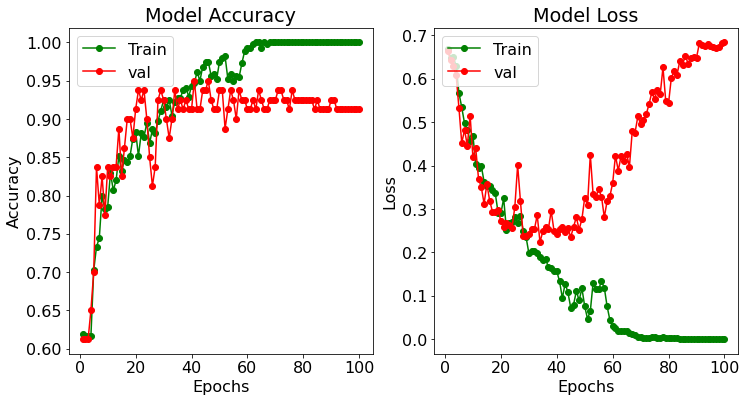

In [41]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Saving Model

In [100]:
model.save('ocular_disease_CNN_model.h5')

### Ocular Disease Prediction Function

In [42]:
def import_and_predict(image_data, label):
    
    #read image
    img = cv2.imread(image_data)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    # resize and reshape the image
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    img_reshape = img_resize[np.newaxis,...]
    
    #predict the image
    prediction = model.predict(img_reshape)
    print(prediction)
    
    label_prediction = label[np.argmax(prediction)]
    
    return label_prediction

In [43]:
label = os.listdir(test_dir)

### CNN Model Predictions

In [44]:
image1_dir = os.path.join(test_dir+'Cataract/112_right.jpg')
image2_dir = os.path.join(test_dir+'Normal/394_right.jpg')

In [45]:
# suppressing scientific notation when printing float values
pd.options.display.float_format = '{:.2f}'.format

[[0.99763703 0.00236291]]


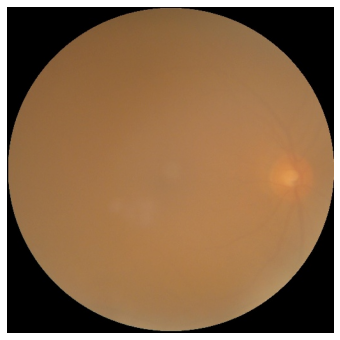

In [46]:
prediction1 = import_and_predict(image1_dir, label)

In [47]:
prediction1

'Cataract'

In [50]:
pd.options.display.float_format = '{:.2f}'.format

[[2.4583493e-08 1.0000000e+00]]


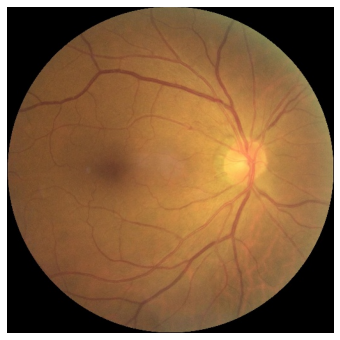

In [51]:
prediction2 = import_and_predict(image2_dir, label)

In [52]:
prediction2

'Normal'

## Bayesian Convolutional Neural Network (BCNN)

In [53]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

### BCNN Model Architecture

In [54]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


In [55]:
model_bayes.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 60, 60, 8)        12304     
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                      

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

### Compiling BCNN Model

In [57]:
def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.05),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

### BCNN Model Training

In [58]:
checkpoint_bcnn_model = ModelCheckpoint("bcnn_model_1.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)

In [61]:
start = time.time()
history_bayes = model_bayes.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_bcnn_model],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 9.4452 - accuracy: 0.5214
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to bcnn_model_1.h5
16/16 [==============================] - 3s 170ms/step - loss: 9.4452 - accuracy: 0.5214 - val_loss: 9.3523 - val_accuracy: 0.4875
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 9.2855 - accuracy: 0.5185
Epoch 2: val_accuracy improved from 0.48750 to 0.51250, saving model to bcnn_model_1.h5
16/16 [==============================] - 3s 171ms/step - loss: 9.2855 - accuracy: 0.5185 - val_loss: 9.1840 - val_accuracy: 0.5125
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 9.1146 - accuracy: 0.5413
Epoch 3: val_accuracy improved from 0.51250 to 0.55000, saving model to bcnn_model_1.h5
16/16 [==============================] - 3s 173ms/step - loss: 9.1146 - accuracy: 0.5413 - val_loss: 9.0209 - val_accuracy: 0.5500
Epoch 4/100
16/16 [==============================] - ETA: 0s 

Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 6.8365 - accuracy: 0.5470
Epoch 30: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 186ms/step - loss: 6.8365 - accuracy: 0.5470 - val_loss: 6.7997 - val_accuracy: 0.5000
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 6.7593 - accuracy: 0.5370
Epoch 31: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 185ms/step - loss: 6.7593 - accuracy: 0.5370 - val_loss: 6.7170 - val_accuracy: 0.4875
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 6.6876 - accuracy: 0.5470
Epoch 32: val_accuracy did not improve from 0.62500
16/16 [==============================] - 3s 187ms/step - loss: 6.6876 - accuracy: 0.5470 - val_loss: 6.6524 - val_accuracy: 0.6250
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 6.6154 - accuracy: 0.5484
Epoch 33: val_accuracy did not improve from 0.62500
16/16 [========

16/16 [==============================] - ETA: 0s - loss: 6.0272 - accuracy: 0.5641
Epoch 59: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 193ms/step - loss: 6.0272 - accuracy: 0.5641 - val_loss: 5.9850 - val_accuracy: 0.5000
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 5.9524 - accuracy: 0.5399
Epoch 60: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 186ms/step - loss: 5.9524 - accuracy: 0.5399 - val_loss: 5.9081 - val_accuracy: 0.5750
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 5.8808 - accuracy: 0.5484
Epoch 61: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 187ms/step - loss: 5.8808 - accuracy: 0.5484 - val_loss: 5.8515 - val_accuracy: 0.5625
Epoch 62/100
16/16 [==============================] - ETA: 0s - loss: 5.8109 - accuracy: 0.5085
Epoch 62: val_accuracy did not improve from 0.63750
16/16 [=====================

16/16 [==============================] - ETA: 0s - loss: 4.7025 - accuracy: 0.5299
Epoch 88: val_accuracy did not improve from 0.67500
16/16 [==============================] - 3s 186ms/step - loss: 4.7025 - accuracy: 0.5299 - val_loss: 4.6784 - val_accuracy: 0.4250
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 4.6629 - accuracy: 0.5071
Epoch 89: val_accuracy did not improve from 0.67500
16/16 [==============================] - 3s 186ms/step - loss: 4.6629 - accuracy: 0.5071 - val_loss: 4.6325 - val_accuracy: 0.5625
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 4.6260 - accuracy: 0.5598
Epoch 90: val_accuracy did not improve from 0.67500
16/16 [==============================] - 3s 189ms/step - loss: 4.6260 - accuracy: 0.5598 - val_loss: 4.5968 - val_accuracy: 0.5250
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 4.5817 - accuracy: 0.5385
Epoch 91: val_accuracy did not improve from 0.67500
16/16 [=====================

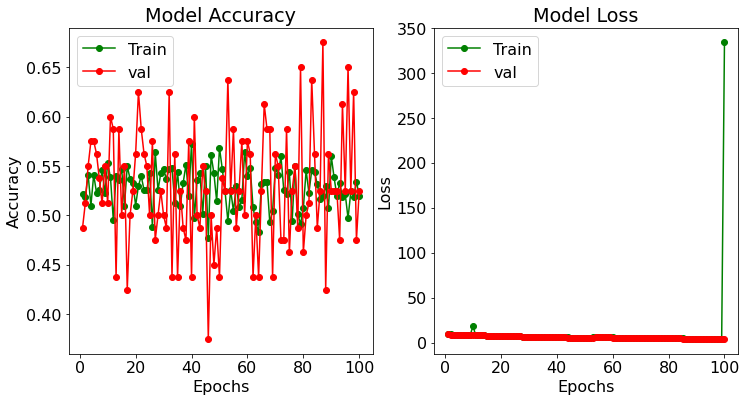

In [62]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes.history["accuracy"],"go-")
plt.plot(epochs,history_bayes.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes.history["loss"],"go-")
plt.plot(epochs,history_bayes.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### BCNN Model Saving

In [101]:
model_bayes.save('ocular_disease_BCNN_model.h5')

### BCNN Ocular Disease Prediction Function

In [63]:
def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 2))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(2)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(2)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(2), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(2), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

In [115]:
def import_and_predict_bayes_v(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 2))
    
    for i in range(300):
        
        predicted_probabilities[i] = model_bayes(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(2)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(2)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bar = ax.bar(np.arange(2), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(2), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [x for x in label])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()
    
    average_estimate = np.array([np.mean(predicted_probabilities[:, i]) for i in range(2)])*100
    prediction_label = label[np.argmax(average_estimate)]
    highest_prediction = average_estimate.max()
    print("Most likely Ocular Condition:", prediction_label, "-", round(highest_prediction,2), "%")
    cert_2p5 = pct_2p5*100
    cert_97p5 = pct_97p5*100
    for i in range(2):
        print(label[i], ": Average estimate = ", round(average_estimate[i],2),
             ": 97.5% ", round(cert_2p5[i], 2), "-", round(cert_97p5[i], 2))

In [106]:
image1_dir = os.path.join(test_dir+'Cataract/112_right.jpg')
image2_dir = os.path.join(test_dir+'Cataract/2140_left.jpg')
image3_dir = os.path.join(test_dir+'Cataract/2155_right.jpg')
image4_dir = os.path.join(test_dir+'Cataract/2231_right.jpg')
image5_dir = os.path.join(test_dir+'Cataract/824_left.jpg')
image6_dir = os.path.join(test_dir+'Normal/42_left.jpg')
image7_dir = os.path.join(test_dir+'Normal/500_right.jpg')
image8_dir = os.path.join(test_dir+'Normal/3207_left.jpg')
image9_dir = os.path.join(test_dir+'Normal/2849_right.jpg')
image10_dir = os.path.join(test_dir+'Normal/3262_left.jpg')

### Predictions and Visualisation

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/4172194512.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


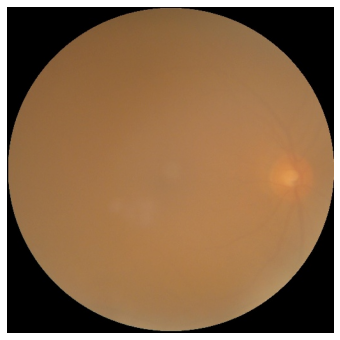

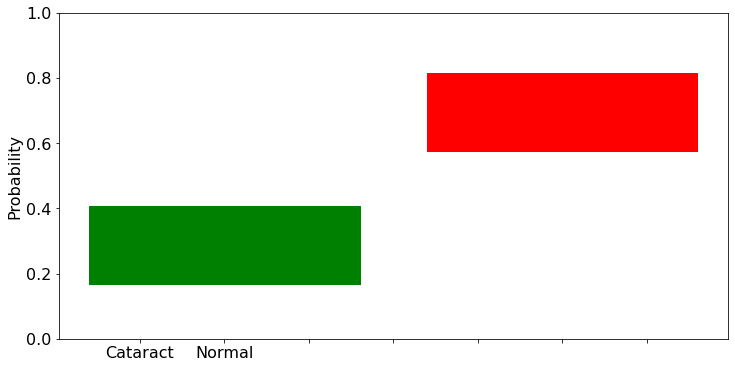

In [64]:
import_and_predict_bayes(image1_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/4172194512.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


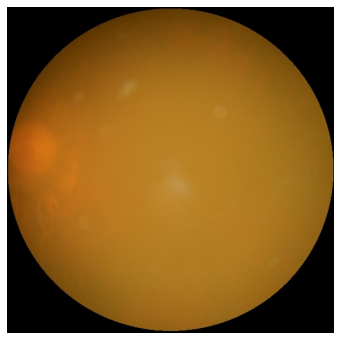

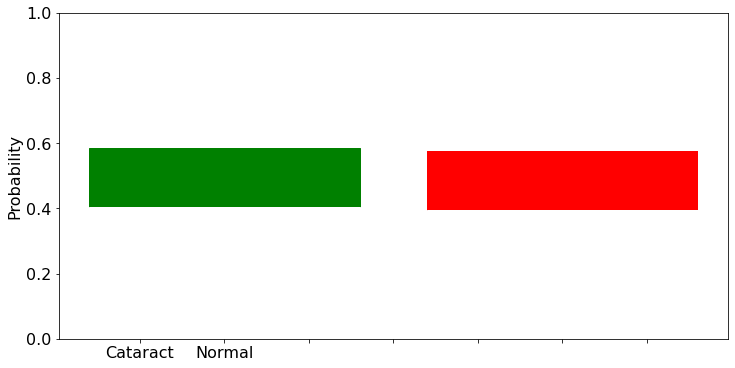

In [107]:
import_and_predict_bayes(image2_dir, label.index('Cataract'))

### Predictions with Credible Intervals and Visualisations

### Cataract Class

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


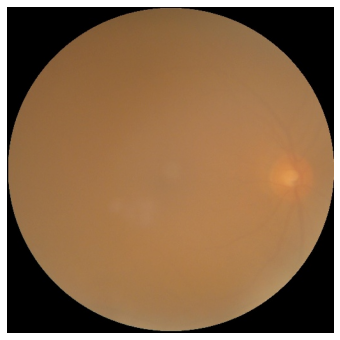

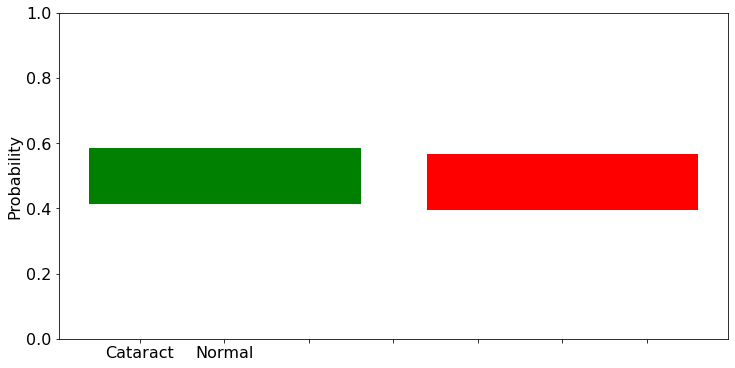

Most likely Ocular Condition: Cataract - 51.16 %
Cataract : Average estimate =  51.16 : 97.5%  43.35 - 58.6
Normal : Average estimate =  48.84 : 97.5%  41.4 - 56.65


In [116]:
import_and_predict_bayes_v(image1_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


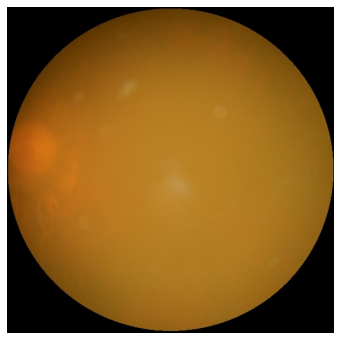

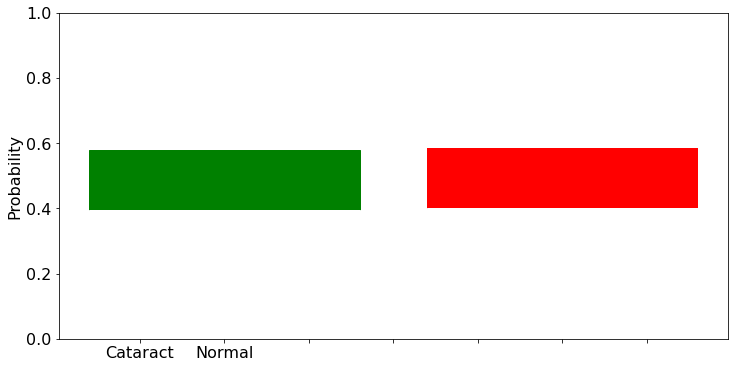

Most likely Ocular Condition: Cataract - 50.06 %
Cataract : Average estimate =  50.06 : 97.5%  41.61 - 57.82
Normal : Average estimate =  49.94 : 97.5%  42.18 - 58.39


In [117]:
import_and_predict_bayes_v(image2_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


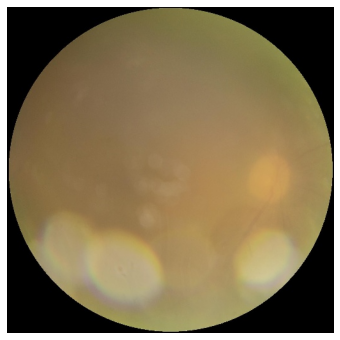

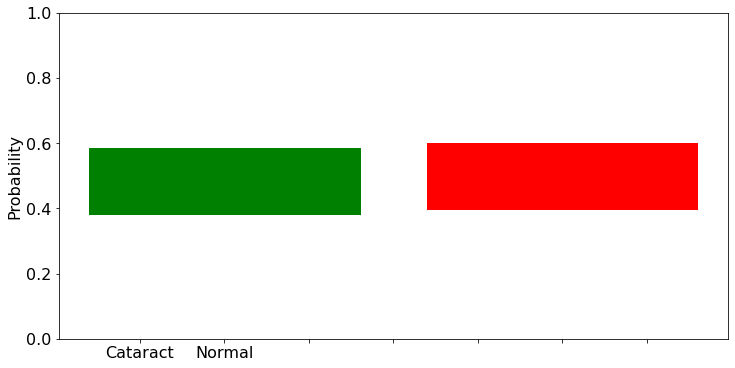

Most likely Ocular Condition: Cataract - 50.48 %
Cataract : Average estimate =  50.48 : 97.5%  39.86 - 58.46
Normal : Average estimate =  49.52 : 97.5%  41.54 - 60.14


In [118]:
import_and_predict_bayes_v(image3_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


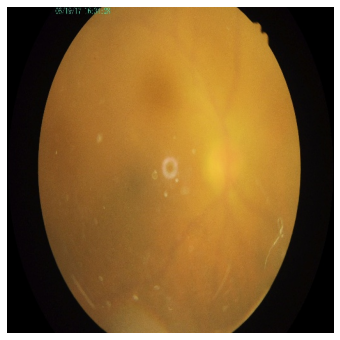

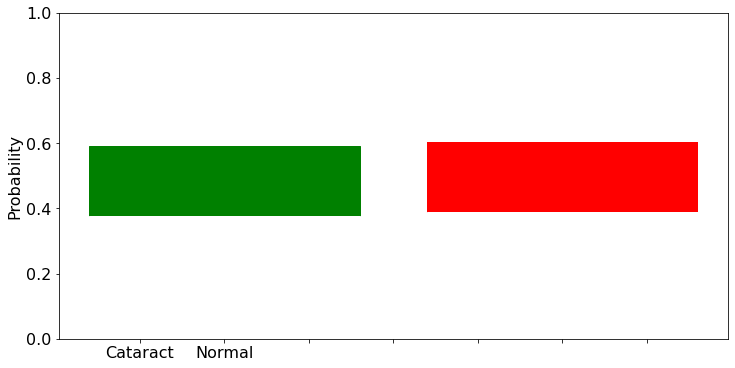

Most likely Ocular Condition: Normal - 50.06 %
Cataract : Average estimate =  49.94 : 97.5%  39.72 - 59.07
Normal : Average estimate =  50.06 : 97.5%  40.93 - 60.28


In [119]:
import_and_predict_bayes_v(image4_dir, label.index('Cataract'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


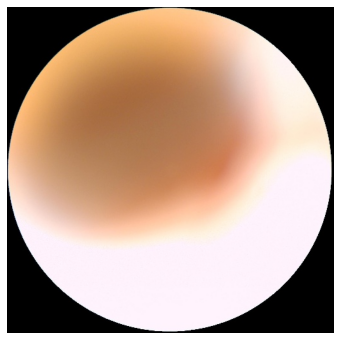

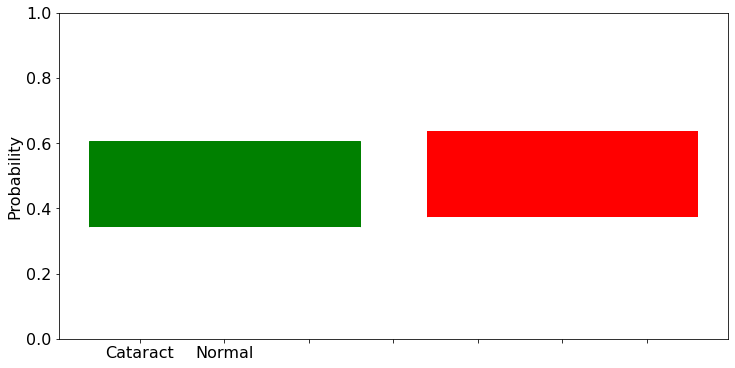

Most likely Ocular Condition: Normal - 50.69 %
Cataract : Average estimate =  49.31 : 97.5%  36.24 - 60.76
Normal : Average estimate =  50.69 : 97.5%  39.24 - 63.76


In [120]:
import_and_predict_bayes_v(image5_dir, label.index('Cataract'))

### Normal Class Predictions

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


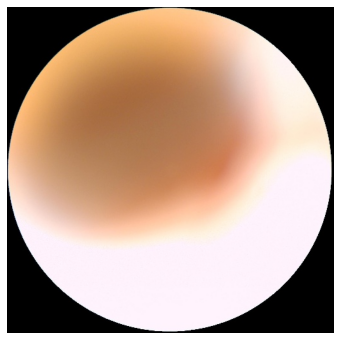

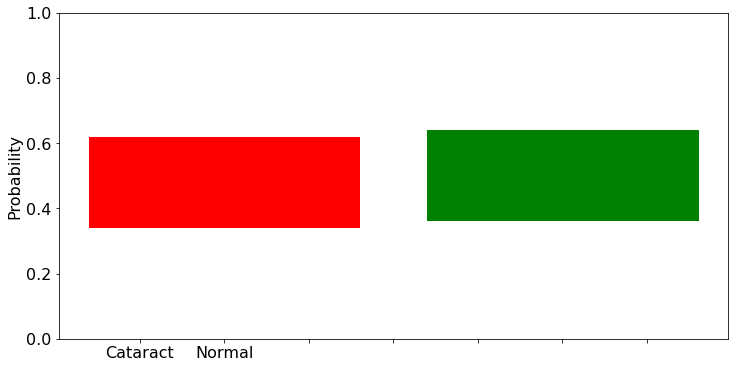

Most likely Ocular Condition: Normal - 50.85 %
Cataract : Average estimate =  49.15 : 97.5%  36.1 - 61.79
Normal : Average estimate =  50.85 : 97.5%  38.21 - 63.9


In [121]:
import_and_predict_bayes_v(image5_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


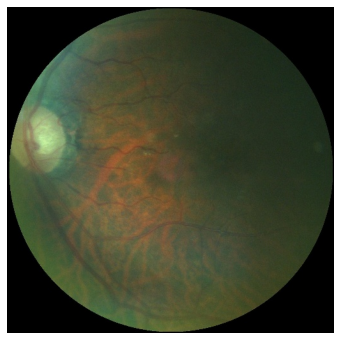

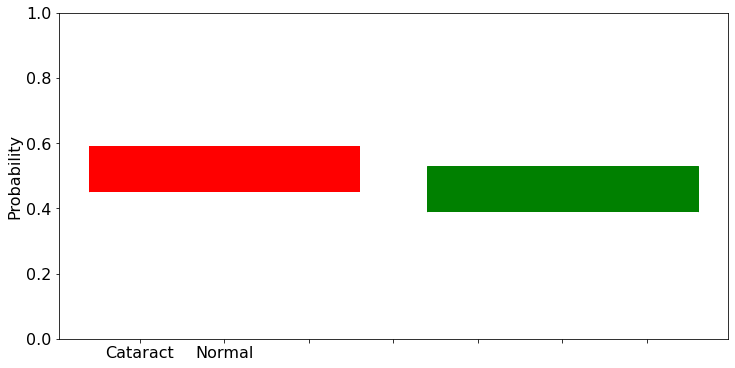

Most likely Ocular Condition: Cataract - 53.22 %
Cataract : Average estimate =  53.22 : 97.5%  47.1 - 59.0
Normal : Average estimate =  46.78 : 97.5%  41.0 - 52.9


In [122]:
import_and_predict_bayes_v(image6_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


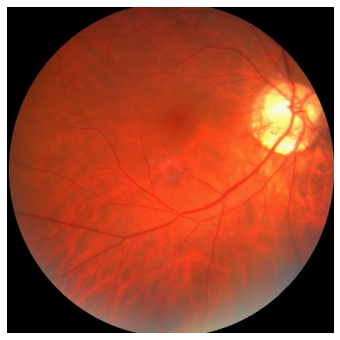

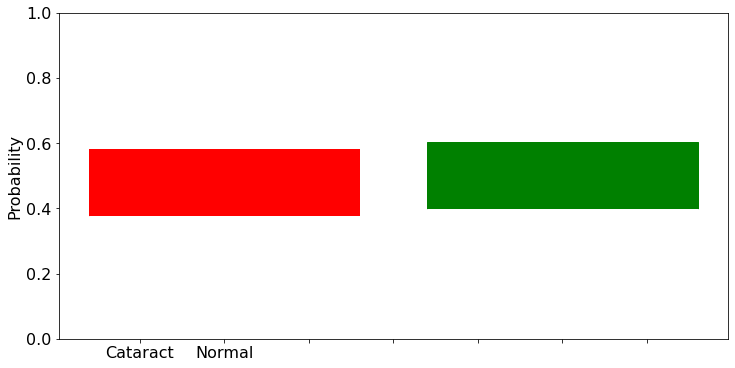

Most likely Ocular Condition: Normal - 50.61 %
Cataract : Average estimate =  49.39 : 97.5%  39.58 - 58.16
Normal : Average estimate =  50.61 : 97.5%  41.84 - 60.42


In [123]:
import_and_predict_bayes_v(image7_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


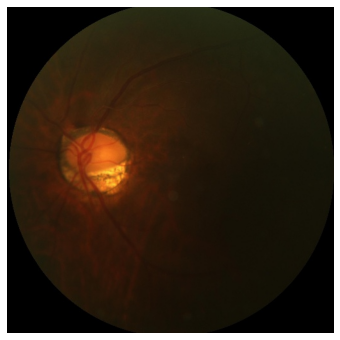

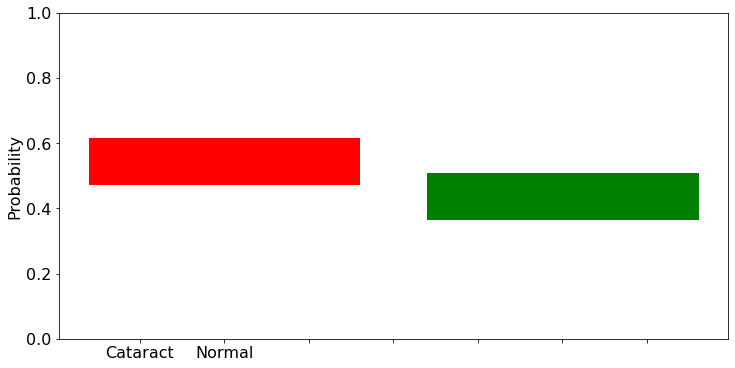

Most likely Ocular Condition: Cataract - 55.59 %
Cataract : Average estimate =  55.59 : 97.5%  49.22 - 61.47
Normal : Average estimate =  44.41 : 97.5%  38.53 - 50.78


In [124]:
import_and_predict_bayes_v(image8_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


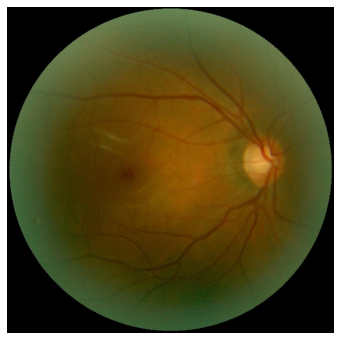

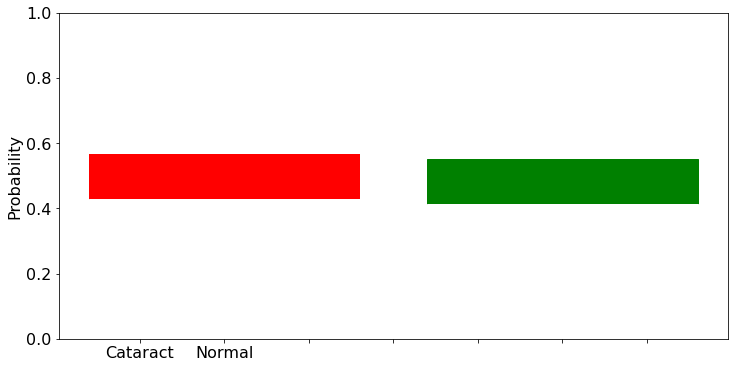

Most likely Ocular Condition: Cataract - 51.1 %
Cataract : Average estimate =  51.1 : 97.5%  44.74 - 56.76
Normal : Average estimate =  48.9 : 97.5%  43.24 - 55.26


In [125]:
import_and_predict_bayes_v(image9_dir, label.index('Normal'))

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/1927557421.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


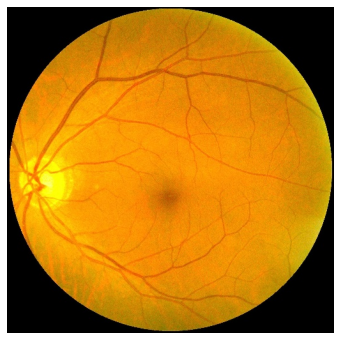

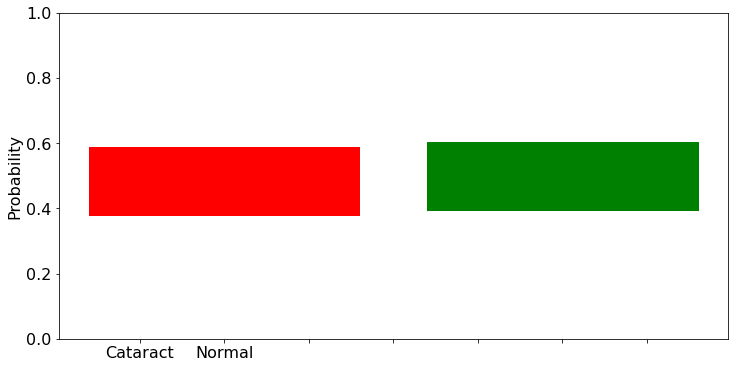

Most likely Ocular Condition: Normal - 50.45 %
Cataract : Average estimate =  49.55 : 97.5%  39.66 - 58.87
Normal : Average estimate =  50.45 : 97.5%  41.13 - 60.34


In [126]:
import_and_predict_bayes_v(image10_dir, label.index('Normal'))

### Random Image Prediction

C:\Users\ELINIM~1\AppData\Local\Temp/ipykernel_8660/4172194512.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + [x for x in label])


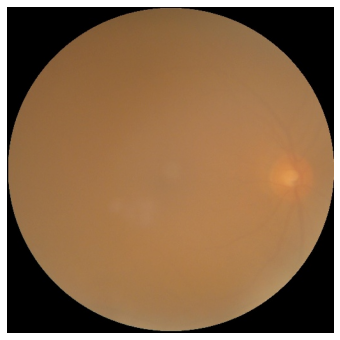

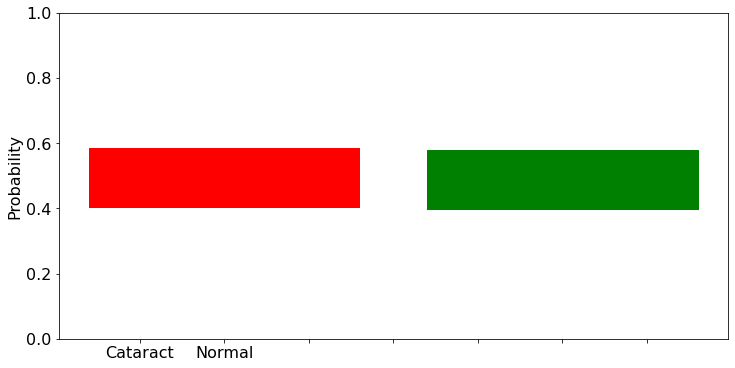

In [102]:
random_image_dir = 'archive/preprocessed_images/303_right.jpg'
import_and_predict_bayes(random_image_dir, label.index('Normal'))

## Model Experimentation
### Hyper-parameter Tuning

In [72]:
def image_generator(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 44,
                                  class_mode = 'binary',
                                  subset='training')
 
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 4,
                                 class_mode = 'binary')    
    
    return train_generator, test_generator

In [73]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 702 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [81]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/702

model_bayes_2 = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape=(75,75,3), filters=8, kernel_size=16, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(2), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    tfpl.OneHotCategorical(2)
    
])

In [76]:
model_bayes_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_2  (None, 60, 60, 8)        12304     
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        2336      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 64)        18496     
                                                      

# Experiment 1

In [77]:
model_bayes_2.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [78]:
checkpoint_bcnn_model_2 = ModelCheckpoint("bcnn_model_2.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)

In [79]:
start = time.time()
history_bayes_2 = model_bayes_2.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_bcnn_model_2],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 39.1079 - accuracy: 0.5142
Epoch 1: val_accuracy improved from -inf to 0.51250, saving model to bcnn_model_2.h5
16/16 [==============================] - 4s 180ms/step - loss: 39.1079 - accuracy: 0.5142 - val_loss: 25.8589 - val_accuracy: 0.5125
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 28.7470 - accuracy: 0.5171
Epoch 2: val_accuracy improved from 0.51250 to 0.52500, saving model to bcnn_model_2.h5
16/16 [==============================] - 5s 296ms/step - loss: 28.7470 - accuracy: 0.5171 - val_loss: 39.2935 - val_accuracy: 0.5250
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 31008.1660 - accuracy: 0.5028
Epoch 3: val_accuracy did not improve from 0.52500
16/16 [==============================] - 6s 378ms/step - loss: 31008.1660 - accuracy: 0.5028 - val_loss: 117549.0859 - val_accuracy: 0.4625
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 2535140.00

Epoch 27/100
16/16 [==============================] - ETA: 0s - loss: 132380765454336.0000 - accuracy: 0.4801
Epoch 27: val_accuracy did not improve from 0.61250
16/16 [==============================] - 3s 208ms/step - loss: 132380765454336.0000 - accuracy: 0.4801 - val_loss: 123154001297408.0000 - val_accuracy: 0.4375
Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 136013770915840.0000 - accuracy: 0.5185
Epoch 28: val_accuracy did not improve from 0.61250
16/16 [==============================] - 3s 211ms/step - loss: 136013770915840.0000 - accuracy: 0.5185 - val_loss: 100730891403264.0000 - val_accuracy: 0.3375
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 186717982162944.0000 - accuracy: 0.5085
Epoch 29: val_accuracy did not improve from 0.61250
16/16 [==============================] - 3s 210ms/step - loss: 186717982162944.0000 - accuracy: 0.5085 - val_loss: 106884606459904.0000 - val_accuracy: 0.5125
Epoch 30/100
16/16 [=================

16/16 [==============================] - ETA: 0s - loss: 3457668521918464.0000 - accuracy: 0.5313
Epoch 52: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 178ms/step - loss: 3457668521918464.0000 - accuracy: 0.5313 - val_loss: 2365200640507904.0000 - val_accuracy: 0.6375
Epoch 53/100
16/16 [==============================] - ETA: 0s - loss: 3689808014606336.0000 - accuracy: 0.5071
Epoch 53: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 177ms/step - loss: 3689808014606336.0000 - accuracy: 0.5071 - val_loss: 5342644037222400.0000 - val_accuracy: 0.3875
Epoch 54/100
16/16 [==============================] - ETA: 0s - loss: 5697758375706624.0000 - accuracy: 0.5385
Epoch 54: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 178ms/step - loss: 5697758375706624.0000 - accuracy: 0.5385 - val_loss: 10468100168220672.0000 - val_accuracy: 0.3875
Epoch 55/100
16/16 [====================

16/16 [==============================] - ETA: 0s - loss: 26861940944928768.0000 - accuracy: 0.5028
Epoch 77: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 199ms/step - loss: 26861940944928768.0000 - accuracy: 0.5028 - val_loss: 17336246795763712.0000 - val_accuracy: 0.5625
Epoch 78/100
16/16 [==============================] - ETA: 0s - loss: 38469824501776384.0000 - accuracy: 0.5256
Epoch 78: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 201ms/step - loss: 38469824501776384.0000 - accuracy: 0.5256 - val_loss: 50107162944339968.0000 - val_accuracy: 0.3875
Epoch 79/100
16/16 [==============================] - ETA: 0s - loss: 41042544271818752.0000 - accuracy: 0.5228
Epoch 79: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 201ms/step - loss: 41042544271818752.0000 - accuracy: 0.5228 - val_loss: 45566209986396160.0000 - val_accuracy: 0.3875
Epoch 80/100
16/16 [============

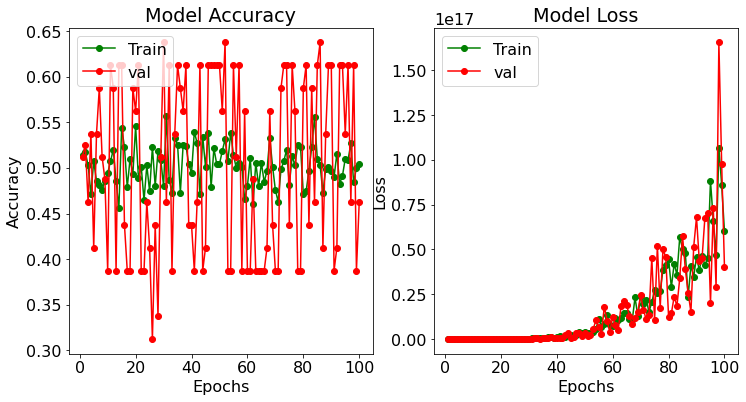

In [80]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes_2.history["accuracy"],"go-")
plt.plot(epochs,history_bayes_2.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes_2.history["loss"],"go-")
plt.plot(epochs,history_bayes_2.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

## Experiment 2

In [105]:
model_bayes_2.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.001),
              metrics = ['accuracy'],
              experimental_run_tf_function = False)
checkpoint_bcnn_model_3 = ModelCheckpoint("bcnn_model_3.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
start = time.time()
history_bayes_3 = model_bayes_2.fit(
      train_generator,
      validation_data = test_generator,
      epochs=100,
      callbacks = [checkpoint_bcnn_model_3],
      verbose=1)
end = time.time()
print('Execution Time:', end - start)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 27.6424 - accuracy: 0.5071
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to bcnn_model_3.h5
16/16 [==============================] - 4s 186ms/step - loss: 27.6424 - accuracy: 0.5071 - val_loss: 33.4240 - val_accuracy: 0.4875
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 118.4089 - accuracy: 0.5000
Epoch 2: val_accuracy improved from 0.48750 to 0.60000, saving model to bcnn_model_3.h5
16/16 [==============================] - 3s 165ms/step - loss: 118.4089 - accuracy: 0.5000 - val_loss: 304.5453 - val_accuracy: 0.6000
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 2101.8928 - accuracy: 0.5057
Epoch 3: val_accuracy did not improve from 0.60000
16/16 [==============================] - 3s 162ms/step - loss: 2101.8928 - accuracy: 0.5057 - val_loss: 10043.3008 - val_accuracy: 0.3875
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 24166.8027

16/16 [==============================] - 3s 202ms/step - loss: 39795998720.0000 - accuracy: 0.4929 - val_loss: 42273386496.0000 - val_accuracy: 0.5125
Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 43661914112.0000 - accuracy: 0.5285
Epoch 28: val_accuracy did not improve from 0.61250
16/16 [==============================] - 3s 202ms/step - loss: 43661914112.0000 - accuracy: 0.5285 - val_loss: 63031386112.0000 - val_accuracy: 0.5875
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 53944102912.0000 - accuracy: 0.5342
Epoch 29: val_accuracy did not improve from 0.61250
16/16 [==============================] - 3s 211ms/step - loss: 53944102912.0000 - accuracy: 0.5342 - val_loss: 76442296320.0000 - val_accuracy: 0.5875
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 89078923264.0000 - accuracy: 0.4957
Epoch 30: val_accuracy did not improve from 0.61250
16/16 [==============================] - 3s 197ms/step - loss: 8907892326

Epoch 54/100
16/16 [==============================] - ETA: 0s - loss: 1962096328704.0000 - accuracy: 0.4630
Epoch 54: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 193ms/step - loss: 1962096328704.0000 - accuracy: 0.4630 - val_loss: 1918050762752.0000 - val_accuracy: 0.4875
Epoch 55/100
16/16 [==============================] - ETA: 0s - loss: 2670163394560.0000 - accuracy: 0.5100
Epoch 55: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 190ms/step - loss: 2670163394560.0000 - accuracy: 0.5100 - val_loss: 2430458658816.0000 - val_accuracy: 0.5625
Epoch 56/100
16/16 [==============================] - ETA: 0s - loss: 2335246909440.0000 - accuracy: 0.4786
Epoch 56: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 190ms/step - loss: 2335246909440.0000 - accuracy: 0.4786 - val_loss: 3902085529600.0000 - val_accuracy: 0.5875
Epoch 57/100
16/16 [==============================] - E

Epoch 80/100
16/16 [==============================] - ETA: 0s - loss: 18957197115392.0000 - accuracy: 0.5342
Epoch 80: val_accuracy did not improve from 0.63750
16/16 [==============================] - 4s 218ms/step - loss: 18957197115392.0000 - accuracy: 0.5342 - val_loss: 12496532406272.0000 - val_accuracy: 0.4625
Epoch 81/100
16/16 [==============================] - ETA: 0s - loss: 15662968733696.0000 - accuracy: 0.4957
Epoch 81: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 214ms/step - loss: 15662968733696.0000 - accuracy: 0.4957 - val_loss: 11179034411008.0000 - val_accuracy: 0.5375
Epoch 82/100
16/16 [==============================] - ETA: 0s - loss: 18357136916480.0000 - accuracy: 0.4701
Epoch 82: val_accuracy did not improve from 0.63750
16/16 [==============================] - 3s 211ms/step - loss: 18357136916480.0000 - accuracy: 0.4701 - val_loss: 19083640700928.0000 - val_accuracy: 0.6125
Epoch 83/100
16/16 [==========================

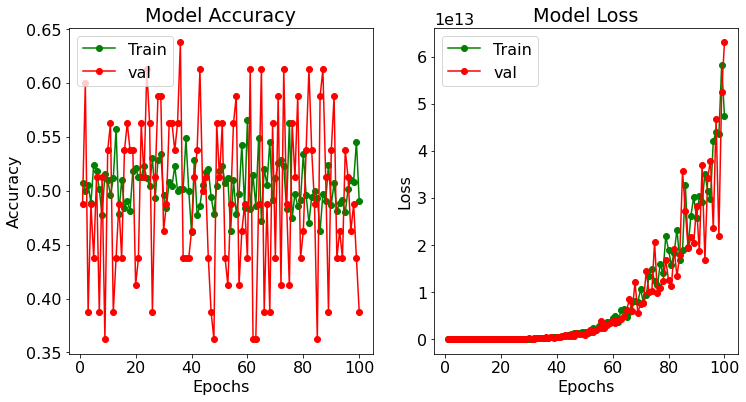

In [127]:
fig = plt.figure(figsize=(12,6))
epochs = range(1,101)
plt.subplot(1,2,1)
plt.plot(epochs,history_bayes_3.history["accuracy"],"go-")
plt.plot(epochs,history_bayes_3.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_bayes_3.history["loss"],"go-")
plt.plot(epochs,history_bayes_3.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()